<a href="https://colab.research.google.com/github/dvircohen0/GAN/blob/main/CoGAN_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files 
files.upload()

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d jessicali9530/celeba-dataset

 99% 1.31G/1.33G [01:01<00:00, 19.8MB/s]
100% 1.33G/1.33G [01:01<00:00, 23.3MB/s]


In [ ]:
!unzip "/content/celeba-dataset.zip"

In [14]:
import os
import random
import argparse
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid
import cv2 as cv

In [3]:
dataroot = "/content/img_align_celeba/"
workers = 2
batch_size = 10
image_size = 32
nc = 3
nz = 100
ngf = 32
ndf = 32
num_epochs = 3
lr = 0.0002
beta1 = 0.5
ngpu = 4
sample_interval = 400

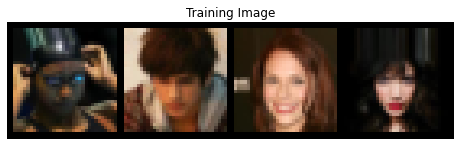

In [66]:
dataset =dset.ImageFolder(root=dataroot,
                          transform = transforms.Compose([
                              transforms.Resize(image_size),
                              transforms.CenterCrop(image_size),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5,0.5), (0.5,0.5,0.5))]))

dataloader1 = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle = True, num_workers=workers)
dataloader2 = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle = True, num_workers=workers)
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

real_batch = next(iter(dataloader1))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Image")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:4],
                                         padding=2, normalize=True).cpu(),(1,2,0)))

In [67]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [6]:
class CoupledGenerators(nn.Module):
  def __init__(self):
    super(CoupledGenerators, self).__init__()
    self.init_size = image_size //4
    self.fc = nn.Sequential(nn.Linear(nz, 128* self.init_size ** 2))
    self.shared_conv = nn.Sequential(
        nn.BatchNorm2d(128),
        nn.Upsample(scale_factor=2),
        nn.BatchNorm2d(128, 0.8),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Upsample(scale_factor=2)
    )

    self.G1 = nn.Sequential(
        nn.Conv2d(128, 64, 3, stride=1, padding=1),
        nn.BatchNorm2d(64, 0.8),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(64, nc, 3, stride=1, padding=1),
        nn.Tanh(),)

    self.G2 = nn.Sequential(
        nn.Conv2d(128, 64, 3, stride=1, padding=1),
        nn.BatchNorm2d(64, 0.8),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(64, nc, 3, stride=1, padding=1),
        nn.Tanh(),)  

  def forward(self, noise):
    out = self.fc(noise)
    out = out.view(out.shape[0], 128, self.init_size, self.init_size)
    img_emb = self.shared_conv(out)
    img1 = self.G1(img_emb)
    img2 = self.G2(img_emb)
    return img1, img2      

In [69]:
class CoupledDiscriminators(nn.Module):
  def __init__(self):
    super(CoupledDiscriminators, self).__init__()
    def discriminator_block(in_filters, out_filters, bn=True):
      block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1)]
      if bn:
        block.append(nn.BatchNorm2d(out_filters, 0.8))
      block.extend ([nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)])
      return block

    self.shared_conv = nn.Sequential(
        *discriminator_block(nc, 16, bn=False),
        *discriminator_block(16, 32),
        *discriminator_block(32, 64),
        *discriminator_block(64, 128),
    )

    ds_size = image_size // 2 ** 4
    self.D1 = nn.Linear(128 * ds_size ** 2, 1)
    self.D2 = nn.Linear(128 * ds_size ** 2, 1)

  def forward(self, img1, img2):
    out = self.shared_conv(img1)
    out = out.view(out.shape[0], -1)
    validity1 = self.D1(out)
    out = self.shared_conv(img2)
    out = out.view(out.shape[0], -1)
    validity2 = self.D2(out)
    return validity1, validity2

In [70]:
netG = CoupledGenerators().to(device)
netG.apply(weights_init)
print(netG)

CoupledGenerators(
  (fc): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
  )
  (shared_conv): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode=nearest)
    (2): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Upsample(scale_factor=2.0, mode=nearest)
  )
  (G1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Tanh()
  )
  (G2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReL

In [71]:
netD = CoupledDiscriminators().to(device)
netD.apply(weights_init)
print(netD)

CoupledDiscriminators(
  (shared_conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout2d(p=0.25, inplace=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout2d(p=0.25, inplace=False)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Dropout2d(p=0.25, inplace=False)
 

In [72]:
loss = nn.MSELoss()
real_label = 1
fake_label = 0
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [73]:
Tensor = torch.cuda.FloatTensor 
for epoch in range(num_epochs):
  for i, ((imgs1,_), (imgs2, _)) in enumerate(zip(dataloader1, dataloader2)):
    batch_size = imgs1.shape[0]

    valid = Variable(Tensor(batch_size, 1).fill_(1.0), requires_grad=False)
    fake = Variable(Tensor(batch_size, 1).fill_(0.0), requires_grad=False)

    imgs1 = Variable(imgs1.type(Tensor).expand(imgs1.size(0), 3, image_size, image_size))
    imgs2 = Variable(imgs2.type(Tensor))

    # Train the Generators

    optimizerG.zero_grad()
    z = Variable(Tensor(np.random.normal(0, 1, (batch_size,nz))))
    gen_imgs1, gen_imgs2 = netG(z)
    validity1, validity2 = netD(gen_imgs1, gen_imgs2)
    g_loss = (loss(validity1, valid) + loss(validity2, valid)) / 2
    g_loss.backward()
    optimizerG.step()

    # Train the Discriminator
    optimizerD.zero_grad()
    validity1_real, validity2_real = netD(imgs1, imgs2)
    validity1_fake, validity2_fake = netD(gen_imgs1.detach(), gen_imgs2.detach())
    d_loss = (loss(validity1_real, valid) + loss(validity2_real, valid) + 
              loss(validity1_fake, fake) + loss(validity2_fake, fake)) / 4
    d_loss.backward()
    optimizerD.step()

    batches_done = epoch * len(dataloader1) + i
    if batches_done % sample_interval == 0:
        print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
        % (epoch, num_epochs, i, len(dataloader1), d_loss.item(), g_loss.item()))


[Epoch 0/3] [Batch 0/20260] [D loss: 0.490882] [G loss: 0.995687]
[Epoch 0/3] [Batch 400/20260] [D loss: 0.268129] [G loss: 0.236506]
[Epoch 0/3] [Batch 800/20260] [D loss: 0.242136] [G loss: 0.232005]
[Epoch 0/3] [Batch 1200/20260] [D loss: 0.222359] [G loss: 0.240104]
[Epoch 0/3] [Batch 1600/20260] [D loss: 0.251700] [G loss: 0.260422]
[Epoch 0/3] [Batch 2000/20260] [D loss: 0.240481] [G loss: 0.344247]
[Epoch 0/3] [Batch 2400/20260] [D loss: 0.238864] [G loss: 0.243005]
[Epoch 0/3] [Batch 2800/20260] [D loss: 0.247823] [G loss: 0.273769]
[Epoch 0/3] [Batch 3200/20260] [D loss: 0.221860] [G loss: 0.281875]
[Epoch 0/3] [Batch 3600/20260] [D loss: 0.277917] [G loss: 0.230531]
[Epoch 0/3] [Batch 4000/20260] [D loss: 0.218459] [G loss: 0.279348]
[Epoch 0/3] [Batch 4400/20260] [D loss: 0.231526] [G loss: 0.317034]
[Epoch 0/3] [Batch 4800/20260] [D loss: 0.209373] [G loss: 0.238515]
[Epoch 0/3] [Batch 5200/20260] [D loss: 0.257535] [G loss: 0.271407]
[Epoch 0/3] [Batch 5600/20260] [D loss:

In [76]:
torch.save(netG.state_dict(), "cogan_generator_pytorch.h5")

In [17]:
device = torch.device("cuda")
model = CoupledGenerators()
model.load_state_dict(torch.load("cogan_generator_pytorch.h5"))
model.to(device)

CoupledGenerators(
  (fc): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
  )
  (shared_conv): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode=nearest)
    (2): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Upsample(scale_factor=2.0, mode=nearest)
  )
  (G1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Tanh()
  )
  (G2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReL

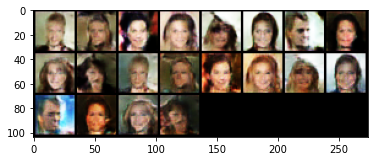

In [21]:
Tensor = torch.cuda.FloatTensor 
z = Variable(Tensor(np.random.normal(0, 1, (batch_size,nz))))
gen_imgs1, gen_imgs2 = model(z)
gen_imgs = torch.cat((gen_imgs1.data, gen_imgs2.data), 0)
save_image(gen_imgs, "results.png", nrow=8, normalize=True)
img = cv.imread("results.png")[:,:,::-1]
plt.imshow(img)
